# Benchmark in hESC dataset

The data is from 'Exploring genetic interaction manifolds constructed from rich single-cell phenotypes', but data is downloaded from beeline https://zenodo.org/records/3701939

## Import libraries and set working directory

In [2]:
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import subprocess

BASE_DIR = '/your/working/directory'
case_path = os.path.join(BASE_DIR, 'BenchmarkHESC')
data_path = os.path.join(case_path, 'data')
output_path = os.path.join(case_path, 'output')
os.makedirs(output_path, exist_ok=True)

## pySCENIC method

please prepare or install pySCENIC and download resources from pySCENIC (https://resources.aertslab.org/cistarget/databases/), and replace 'pyscenic' below in step 1 and 2-3 after '!' with your own pyscenic location.

In [29]:
def run_scenic(data_path, output_path, seed=-1):
    from pyscenic.utils import load_motifs
    from pyscenic.aucell import aucell
    from pyscenic.rss import regulon_specificity_scores
    from pyscenic.cli.utils import load_signatures
    RESOURCES_FOLDERNAME = data_path
    RESULTS_FOLDERNAME = output_path
    FIGURES_FOLDERNAME = output_path
    AUXILLIARIES_FOLDERNAME = data_path
    DATASET_ID = 'hESC'
    RANKING_DBS_FNAMES = list(map(lambda fn: os.path.join(AUXILLIARIES_FOLDERNAME, fn),
                           ['hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather',
                           'hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.genes_vs_motifs.rankings.feather']))
    MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDERNAME, 'motifs-v9-nr.hgnc-m0.001-o0.0.tbl')
    MM_TFS_FNAME = os.path.join(RESULTS_FOLDERNAME, 'hg_tfs.txt')
    COUNTS_QC_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, f'{DATASET_ID}.qc.counts.csv')
    ADJACENCIES_FNAME = os.path.join(RESULTS_FOLDERNAME, f'{DATASET_ID}.adjacencies.tsv')
    MOTIFS_FNAME = os.path.join(RESULTS_FOLDERNAME, f'{DATASET_ID}.motifs.csv')
    pd_motifs = pd.read_csv(MOTIF_ANNOTATIONS_FNAME, sep='\t')
    mm_tfs = pd_motifs.gene_name.unique()
    with open(MM_TFS_FNAME, 'wt') as f:
        f.write('\n'.join(mm_tfs) + '\n')
    expData = pd.read_csv('hESC_ExpressionData.csv', index_col=0).transpose()
    adata = sc.AnnData(X=expData, dtype=np.float32)
    adata.obs['cell_type'] = 'RSS'
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    # STEP 1: Network inference based on GRNBoost2 from CLI
    df_counts_qc = adata.to_df()
    df_counts_qc.to_csv(COUNTS_QC_MTX_FNAME)
    !pyscenic grn {COUNTS_QC_MTX_FNAME} {MM_TFS_FNAME} -o {ADJACENCIES_FNAME} --num_workers 32
    # STEP 2-3: Regulon prediction aka cisTarget from CLI
    DBS_PARAM = ' '.join(RANKING_DBS_FNAMES)
    !pyscenic ctx {ADJACENCIES_FNAME} {DBS_PARAM} --annotations_fname {MOTIF_ANNOTATIONS_FNAME} --expression_mtx_fname {COUNTS_QC_MTX_FNAME} --output {MOTIFS_FNAME} --num_workers 32
    df_motifs = load_motifs(MOTIFS_FNAME)
    # STEP 4: Cellular enrichment aka AUCell
    sig = load_signatures(MOTIFS_FNAME)
    auc_mtx = aucell(df_counts_qc, sig, num_workers=32)
    rss = regulon_specificity_scores(auc_mtx, adata.obs.cell_type)
    df = rss.transpose()
    df.rename(index=lambda x: x.replace("(+)", ""), inplace=True)
    df = pd.DataFrame(df).sort_values(by='RSS', ascending=False)
    return df

## CEFCON method

CEFCON needs NichNet as input, please download from https://github.com/saeyslab/nichenetr

In [28]:
def run_cefcon(data_path, output_path, seed=-1):
    import cefcon as cf
    expData = pd.read_csv(os.path.join(data_path, 'hESC_ExpressionData.csv'), index_col=0).transpose()
    pseudotime = pd.read_csv(os.path.join(data_path, 'hESC_PseudoTime.csv'), index_col=0)
    logFC = pd.read_csv(os.path.join(data_path, 'hESC_DEgenes_MAST_hvg1000_sp4.csv'), index_col=0)
    network_data = pd.read_csv(os.path.join(data_path, 'NicheNet_human.csv'), index_col=None, header=0)
    adata = sc.AnnData(X=expData, dtype=np.float32)
    adata.layers['log_transformed'] = adata.X.copy()
    sc.pp.highly_variable_genes(adata, n_top_genes=1000)
    adata = adata[:, adata.var.highly_variable]
    adata.obs['all_pseudotime'] = pseudotime['PseudoTime']
    logFC.rename(columns={'logFC': 'all_logFC'}, inplace=True)
    adata.var = pd.merge(adata.var, logFC, left_index=True, right_index=True, how='left')
    data = cf.data_preparation(input_expData=adata, input_priorNet=network_data)
    cefcon_results_dict = {}
    for li, data_li in data.items():
        cefcon_GRN_model = cf.NetModel(epochs=350, repeats=1, cuda='0', seed=seed)
        cefcon_GRN_model.run(data_li)
        cefcon_results = cefcon_GRN_model.get_cefcon_results(edge_threshold_avgDegree=8)
        cefcon_results_dict[li] = cefcon_results
    for li, result_li in cefcon_results_dict.items():
        print(f'Lineage - {li}:')
        result_li.gene_influence_score()
        result_li.driver_regulators()
    result_all = cefcon_results_dict['all']
    gene_info_df = result_all.driver_regulator.sort_values(by='influence_score', ascending=False)
    return gene_info_df

## CellOracle method

In [30]:
def run_celloracle(data_path, output_path, seed=-1):
    import celloracle as co
    expData = pd.read_csv(os.path.join(data_path, 'hESC_ExpressionData.csv'), index_col=0).transpose()
    base_GRN = co.data.load_human_promoter_base_GRN()
    adata = sc.AnnData(X=expData, dtype=np.float32)
    sc.pp.highly_variable_genes(adata, n_top_genes=1000)
    adata = adata[:, adata.var.highly_variable]
    sc.tl.pca(adata)
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=35)
    sc.tl.leiden(adata, resolution=0.7)
    adata.obs['manual_cluster'] = '0'
    adata.layers['raw_count'] = adata.X.copy()
    oracle = co.Oracle()
    oracle.import_anndata_as_normalized_count(adata=adata, cluster_column_name="manual_cluster", embedding_name="X_pca")
    oracle.import_TF_data(TF_info_matrix=base_GRN)
    oracle.perform_PCA()
    n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
    n_comps = min(n_comps, 50)
    n_cell = oracle.adata.shape[0]
    k = int(0.025*n_cell)
    oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=4)
    links = oracle.get_links(cluster_name_for_GRN_unit="manual_cluster", alpha=10, verbose_level=10, model_method='bayesian_ridge')
    links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
    links.get_network_score()
    gene_info_df = pd.DataFrame(links.merged_score['degree_centrality_all'].sort_values(ascending=False))
    return gene_info_df

## Our method

In [31]:
def run_cautrigger(data_path, output_path, seed=-1):
    from CauTrigger.utils import set_seed
    from CauTrigger.model import CauTrigger
    import anndata
    expData = pd.read_csv(os.path.join(data_path, 'hESC_ExpressionData.csv'), index_col=0).transpose()
    adata = sc.AnnData(X=expData, dtype=np.float32)
    sc.pp.highly_variable_genes(adata, n_top_genes=1000, flavor='cell_ranger')
    hESC = adata[:, adata.var.highly_variable]
    Trrust = pd.read_table(os.path.join(data_path, 'trrust_rawdata.human.tsv'), header=None)
    Trrust_TF = Trrust.iloc[:, 0].dropna().unique()
    Trrust_nonTF = np.setdiff1d(Trrust.iloc[:, 1].dropna().unique(), Trrust_TF)
    hESC_pt = pd.read_csv(os.path.join(data_path, 'hESC_PseudoTime.csv'), index_col=0)
    hESC_pt['cell_type_1'] = np.where(hESC_pt.index.str.contains('00h'), 0, np.where(hESC_pt.index.str.contains('96h'), 1, np.nan))
    hESC_deg = pd.read_csv(os.path.join(data_path, 'hESC_DEgenes_MAST_hvg1000_sp4.csv'), index_col=0)
    hESC.obs = hESC_pt
    start_TF = hESC[(hESC.obs['cell_type_1'] == 0), np.intersect1d(hESC.var_names, Trrust_TF)]
    end_TF = hESC[(hESC.obs['cell_type_1'] == 1), np.intersect1d(hESC.var_names, Trrust_TF)]
    start_down = hESC[(hESC.obs['cell_type_1'] == 0), np.intersect1d(hESC.var_names, Trrust_nonTF)]
    end_down = hESC[(hESC.obs['cell_type_1'] == 1), np.intersect1d(hESC.var_names, Trrust_nonTF)]
    adata = anndata.concat([start_TF.copy(), end_TF.copy()])
    adata.obs['labels'] = np.repeat([0, 1], [start_TF.shape[0], end_TF.shape[0]])
    adata.obsm['X_down'] = anndata.concat([start_down, end_down]).X.copy()
    init_weight = pd.DataFrame({'gene':adata.var_names})
    mESC_deg1 = hESC_deg.copy()
    mESC_deg1['gene'] = mESC_deg1.index
    init_weight1 = pd.merge(init_weight, mESC_deg1, on='gene', how='left')
    min_value = init_weight1['logFC'].min()
    max_value = init_weight1['logFC'].max()
    init_weight1['logFC'] = init_weight1['logFC'].apply(lambda x: (x - min_value) / (max_value - min_value) * 0.5 + 0.5 if pd.notnull(x) else x)
    init_weight1['logFC'] = init_weight1['logFC'].fillna(0.5)
    prior_probs = np.array(init_weight1['logFC'])
    set_seed(seed)
    model = CauTrigger(
            adata,
            n_causal=2,
            n_latent=10,
            n_hidden=256,
            n_layers_encoder=1,
            n_layers_decoder=1,
            n_layers_dpd=1,
            dropout_rate_encoder=0.5,
            dropout_rate_decoder=0.5,
            dropout_rate_dpd=0.5,
            use_batch_norm='none',
            use_batch_norm_dpd=True,
            decoder_linear=True,
            dpd_linear=False,
            init_weight=None,
            init_thresh=0.0,
            update_down_weight=False,
            attention=True,
            att_mean=False,
        )
    model.pretrain_attention(prior_probs=prior_probs, max_epochs=100)
    model.train(max_epochs=500, stage_training=True, im_factor=1)
    weight_df = model.get_up_feature_weights(normalize=True, method="Model", sort_by_weight=False)[0]
    model_res = pd.DataFrame({'weight_value': weight_df['weight'], }).sort_values('weight_value', ascending=False)
    return model_res

## Define function to compare all methods

In [37]:
def run_algorithms(algorithms, run_times, top_k, data_path, output_path):
    algorithm_functions = {
        'CauTrigger': run_cautrigger,
        'CEFCON': run_cefcon,
        'CellOracle': run_celloracle,
        'SCENIC': run_scenic,
    }
    all_runs_results = {}
    for algorithm_name in algorithm_functions.keys():
        run_algorithm = algorithm_functions[algorithm_name]
        columns = [f'{algorithm_name}_{i+1}' for i in range(run_times)]
        top_k_genes_df = pd.DataFrame(index=range(top_k), columns=columns)
        for i in range(run_times):
            gene_info_df = run_algorithm(data_path, output_path, seed=i)
            top_k_genes = gene_info_df.index[:top_k]
            top_k_genes_df[f'{algorithm_name}_{i+1}'] = top_k_genes
        all_runs_results[algorithm_name] = top_k_genes_df
    return all_runs_results

## Load ground truths

The GO sets are directly from https://www.geneontology.org/, ESC_Cell2011 and ESC_Reproduction2008 are from https://github.com/WPZgithub/CEFCON/tree/main/ground_truths/driver_regulators.

In [9]:
def load_ground_truth(data_path):
    hESC_ground_truth = {}
    Trrust_human = pd.read_table(os.path.join(data_path, 'trrust_rawdata.human.tsv'), header=None)
    Trrust_human_TF = Trrust_human.iloc[:, 0].dropna().unique()
    hESC_files = [
        ('cell_fate_commitment', 'GO_CELL_FATE_COMMITMENT.txt'),
        ('stem_cell_population_maintenance', 'GO_STEM_CELL_POPULATION_MAINTENANCE.txt'),
        ('endoderm_development', 'GO_ENDODERM_DEVELOPMENT.txt')
    ]
    for name, file in hESC_files:
        df = pd.read_csv(os.path.join(data_path, file))
        hESC_ground_truth[name] = set(np.intersect1d(df.iloc[:, 0], Trrust_human_TF))
    cell2011_genes = set(pd.read_csv(os.path.join(data_path, 'ESC_Cell2011.csv'), encoding='latin1')['TFs'])
    reproduction2008_genes = set(pd.read_csv(os.path.join(data_path, 'ESC_Reproduction2008.csv'))['TFs'])
    literature_curated = cell2011_genes.union(reproduction2008_genes)
    hESC_ground_truth['literature_curated'] = literature_curated
    hESC_ground_truth['all'] = set.union(*hESC_ground_truth.values())
    return hESC_ground_truth

## Define function to calculate metrics and plot

In [10]:
def get_top_k_metrics(algorithm_results, ground_truth, top_k=20):
    from scipy.stats import hypergeom
    precision_matrix = []
    recall_matrix = []
    p_value_matrix = []
    f1_score_matrix = []
    if isinstance(ground_truth, pd.DataFrame):
        true_genes = set(ground_truth.iloc[:, 0].values)
    elif isinstance(ground_truth, np.ndarray):
        true_genes = set(np.unique(ground_truth))
    else:
        true_genes = ground_truth
    for method in algorithm_results.columns:
        precision_col = []
        recall_col = []
        p_value_col = []
        f1_score_col = []
        for K in range(1, top_k + 1):
            pred_genes = set(algorithm_results[method].iloc[:K].str.upper())
            TP = len(pred_genes.intersection(true_genes))
            precision = TP / K
            recall = TP / len(true_genes)
            f1_score = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0
            p_value = hypergeom.sf(TP - 1, 15000, len(true_genes), K)
            precision_col.append(precision)
            recall_col.append(recall)
            p_value_col.append(p_value)
            f1_score_col.append(f1_score)
        precision_matrix.append(precision_col)
        recall_matrix.append(recall_col)
        p_value_matrix.append(p_value_col)
        f1_score_matrix.append(f1_score_col)
    metrics = {
        'precision': pd.DataFrame(precision_matrix, columns=range(1, top_k + 1), index=algorithm_results.columns),
        'recall': pd.DataFrame(recall_matrix, columns=range(1, top_k + 1), index=algorithm_results.columns),
        'p_value': pd.DataFrame(p_value_matrix, columns=range(1, top_k + 1), index=algorithm_results.columns),
        'f1_score': pd.DataFrame(f1_score_matrix, columns=range(1, top_k + 1), index=algorithm_results.columns)
    }
    return metrics

In [11]:
def df_to_plot(metric='precision', outpur_dir=False):
    df2plot_dict = {}
    for i in hESC_ground_truth.keys():
        df2plot_dict[i] = pd.DataFrame()
        for j in hESC_algorithm_ret.keys():
            hESC_metrics = get_top_k_metrics(hESC_algorithm_ret[j], hESC_ground_truth[i])
            df2plot_dict[i] = pd.concat([df2plot_dict[i], hESC_metrics[metric]], axis=0)
    df1 = df2plot_dict['cell_fate_commitment'].reset_index().melt(id_vars='index', var_name='timepoint', value_name='value')
    df1[['new_col1', 'new_col2']] = df1['index'].str.split('_', expand=True)
    df1['gt'] = 'cell fate commitment'
    
    df2 = df2plot_dict['stem_cell_population_maintenance'].reset_index().melt(id_vars='index', var_name='timepoint', value_name='value')
    df2[['new_col1', 'new_col2']] = df2['index'].str.split('_', expand=True)
    df2['gt'] = 'stem cell population maintenance'
    
    df3 = df2plot_dict['endoderm_development'].reset_index().melt(id_vars='index', var_name='timepoint', value_name='value')
    df3[['new_col1', 'new_col2']] = df3['index'].str.split('_', expand=True)
    df3['gt'] = 'endoderm development'
    
    df4 = df2plot_dict['literature_curated'].reset_index().melt(id_vars='index', var_name='timepoint', value_name='value')
    df4[['new_col1', 'new_col2']] = df4['index'].str.split('_', expand=True)
    df4['gt'] = 'literature curated'
    
    df5 = df2plot_dict['all'].reset_index().melt(id_vars='index', var_name='timepoint', value_name='value')
    df5[['new_col1', 'new_col2']] = df5['index'].str.split('_', expand=True)
    df5['gt'] = 'all'
    
    merged_df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
    
    g = sns.relplot(data=merged_df, x="timepoint", y="value", hue="new_col1", kind="line", ci=90, marker='o', col='gt')
    (g.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
      .set_axis_labels("Rank cutoff", metric.capitalize())
      .set_titles("{col_name}")
      .set(xticks=range(int(merged_df['timepoint'].min()), int(merged_df['timepoint'].max())+1))
      .tight_layout(w_pad=0)
      )
    g.legend.set_title('')
    g.fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4)
    if outpur_dir:
        g.savefig(f'{outpur_dir}{metric}.png')
    return df2plot_dict

## Run and compare

In [41]:
hESC_ground_truth = load_ground_truth(data_path)

In [38]:
hESC_algorithm_ret = run_algorithms(['CauTrigger', 'CEFCON', 'CellOracle', 'SCENIC'], data_path=data_path, output_path=output_path, run_times=10, top_k=20)

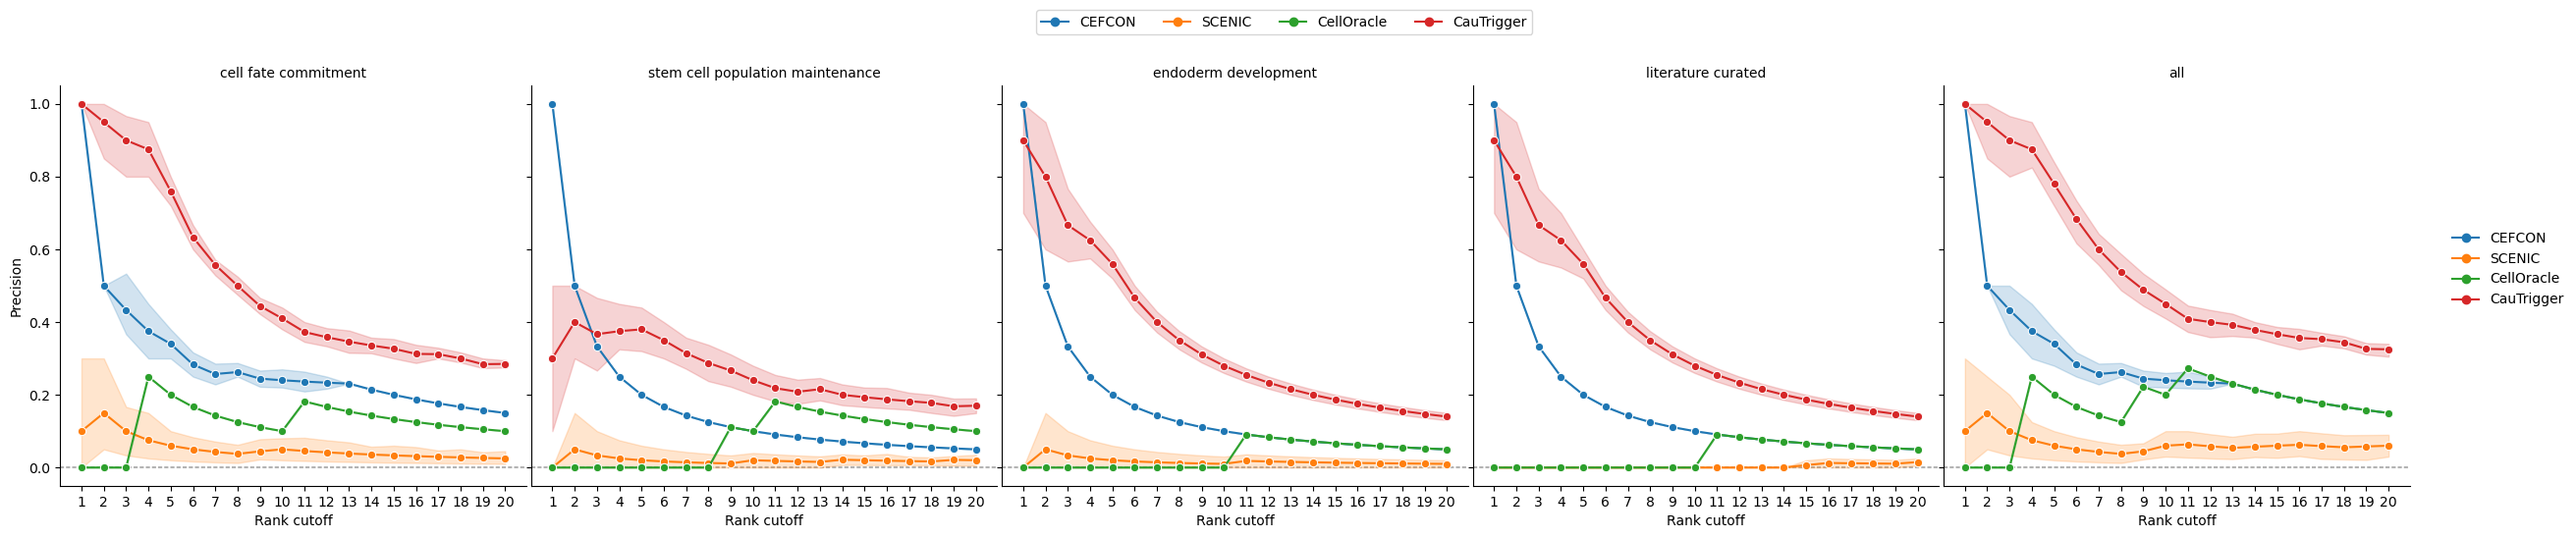

In [40]:
df2plot_dict = df_to_plot(metric='precision', outpur_dir=output_path)

The figure above is slightly different from the one in the article because this is not the final version. Please refer to the article for the official content.